# Introducción

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento



Características con las que viene el archivo recibido:

  -  `DateCrawled` — fecha en la que se descargó el perfil de la base de datos
  -  `VehicleType` — tipo de carrocería del vehículo
  -  `RegistrationYear` — año de matriculación del vehículo
  -  `Gearbox` — tipo de caja de cambios
  -  `Power` — potencia (CV)
  -  `Model` — modelo del vehículo
  -  `Mileage` — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
  -  `RegistrationMonth` — mes de matriculación del vehículo
  -  `FuelType` — tipo de combustible
  -  `Brand` — marca del vehículo
  -  `NotRepaired` — vehículo con o sin reparación
  -  `DateCreated` — fecha de creación del perfil
  -  `NumberOfPictures` — número de fotos del vehículo
  -  `PostalCode` — código postal del propietario del perfil (usuario)
  -  `LastSeen` — fecha de la última vez que el usuario estuvo activo

# Objetivo

- Descargar y examinar los datos.
- Entrenar diferentes modelos con varios hiperparámetros (hacer al menos dos modelos diferentes, pero más es mejor. Recuerdar, varias implementaciones de potenciación del gradiente no cuentan como modelos diferentes). El punto principal de este paso es comparar métodos de potenciación del gradiente con bosque aleatorio, árbol de decisión y regresión lineal.
- Analizar la velocidad y la calidad de los modelos.

# Librerías

In [1]:
%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import lightgbm as lgb

from sklearn.preprocessing import OrdinalEncoder

from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from scipy.spatial import distance
from numpy.random import RandomState

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


# Datos 

In [2]:
try:
    data = pd.read_csv('car_data.csv')
except:
    data = pd.read_csv('/datasets/car_data.csv')


In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.shape

(354369, 16)

Revisando la información de nuestro DataFrame, observamos lo siguiente:

- Tenemos un total de 354369filas con 16 columnas.
- Tenemos datos faltantes en las columnas `VehicleType`, `Gearbox`, `Model`, `FuelType` y `NotRepaired`.
- Las columnas `DateCrawled`, `DateCreated` y `LastSeen` son de tipo "object". Con nuestro análisis, veremos si lo cambiamos a formato DateTime o lo podemos dejar como está.

In [6]:
data.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Teniendo un poco más de detalle de nuestra data, podemos observar que tenemos algunas columnas con valores y distribuciones extrañas. Por ejemplo, la columna `NumberOfPictures` está repleta de 0. Lo que no nos aporta mucha información realmente. La eliminaremos más adelante. Por otro lado, las columnas `Price`, `RegistrationYear`, y `Power` tienen un aumento grande en el último cuarto de datos. Sobretodo se ve en la columna `Power`, donde el valor máximo es mucho más alto que el tercer cuartil. Por último, tenemos la columna `Mileage`, en la cual podemos observar que el valor máximo pareciera ser igual a la mayoría de los datos. Podría deberse a que es el odómetro máximo aceptado por la plataforma.

### Columnas con valores atípicos

#### Veamos como se distribuyen los valores de la columna `Mileage`:

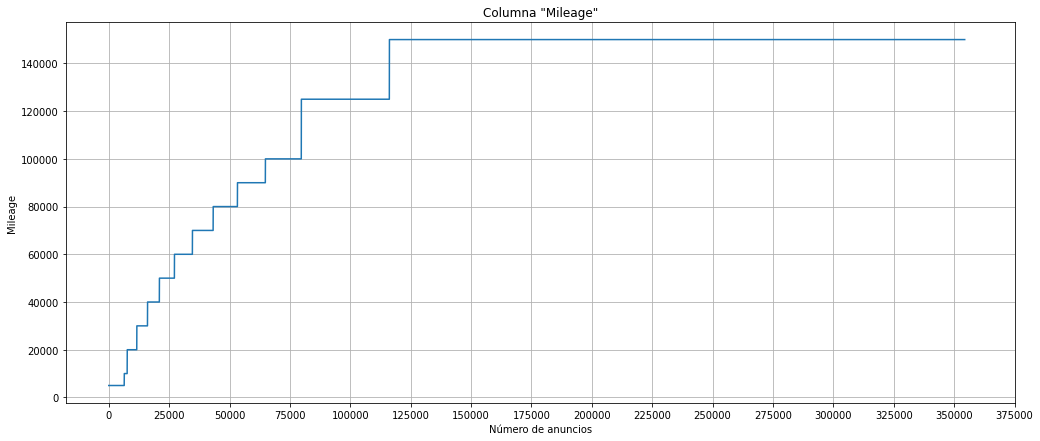

In [7]:
data['Mileage'].sort_values(ignore_index=True).plot(figsize=(17,7), grid=True)
plt.xticks(np.arange(0,375001,25000))
plt.title('Columna "Mileage"')
plt.ylabel('Mileage')
plt.xlabel('Número de anuncios')
plt.show()

Como mencionado anteriormente, los valores de la columna `Mileage` se encuentran escalados. Es probable que esto significa que al subir el anuncio, se presentan algunas opciones para el millaje del vehículo, y no se da la libertad a la persona para colocar cualquier valor. Por lo tanto, podríamos pensar que el valor máximo de esta columna puede ser igual o mayor al millaje del vehículo.

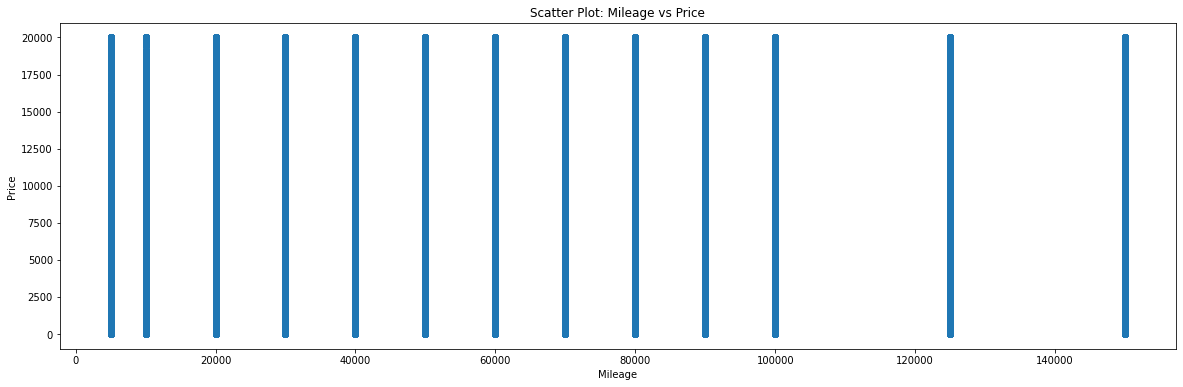

In [8]:
# Eliminar filas con valores NaN en las columnas 'Mileage' y 'Price'
data_scatter = data.dropna(subset=['Mileage', 'Price'])

# Crear el scatter plot usando matplotlib
plt.figure(figsize=(20, 6))
plt.scatter(data_scatter['Mileage'], data_scatter['Price'])
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.title('Scatter Plot: Mileage vs Price')
plt.show()


#### Veamos como se distribuyen los valores de la columna `Power`:

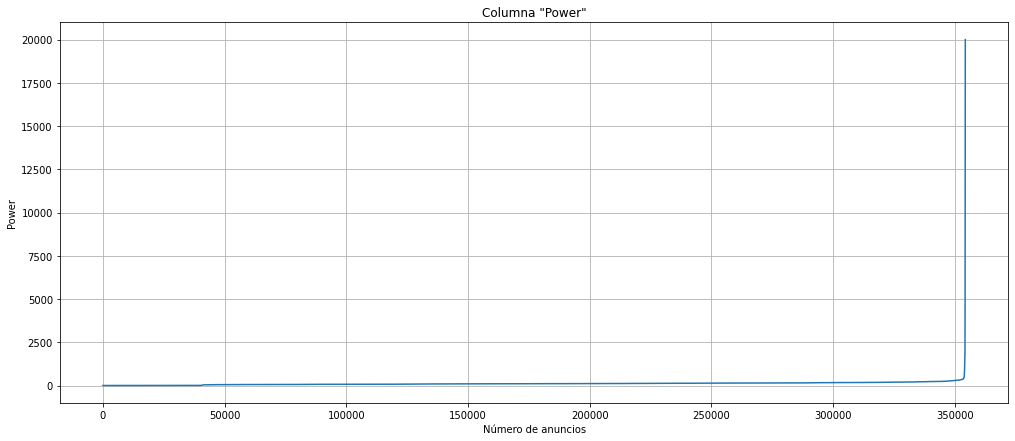

In [9]:
data['Power'].sort_values(ignore_index=True).plot(figsize=(17,7), grid=True)
plt.title('Columna "Power"')
plt.ylabel('Power')
plt.xlabel('Número de anuncios')
plt.show()

Con el gráfico de arriba, no logramos observar de forma clara el problema. Vamos a crear un límite superior y veremos como se distribuyen los valores superiores.

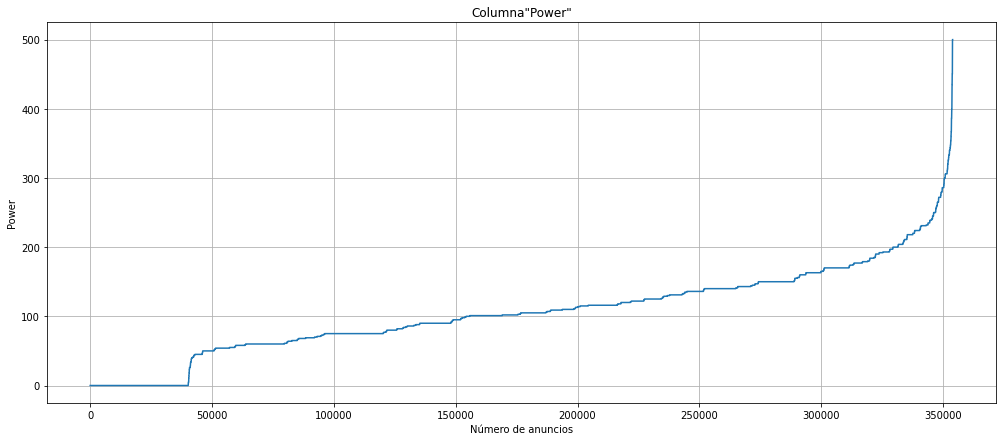

In [10]:
data[data['Power']<=500]['Power'].sort_values(ignore_index=True).plot(figsize=(17,7), grid=True)
plt.title('Columna"Power"')
plt.ylabel('Power')
plt.xlabel('Número de anuncios')
plt.show()

In [11]:
len(data[data['Power']>0])/len(data)

0.8864883779337357

Ahora podemos ver con mayor claridad los valores de la columna `Power`. Y observamos que algunos anuncios que tienen potencia 0 están en el extremo inferior. No tiene mucho sentido esto, deberíamos eliminar estas filas, aún si corresponde a más del 10%. Esperemos que esta eliminación se lleve algunos de los valores vacíos y atípicos de otras columnas. Fijándonos en el extremo superior, podemos ver que los valores parecen tener un crecimiento excesivo a partir de 300.

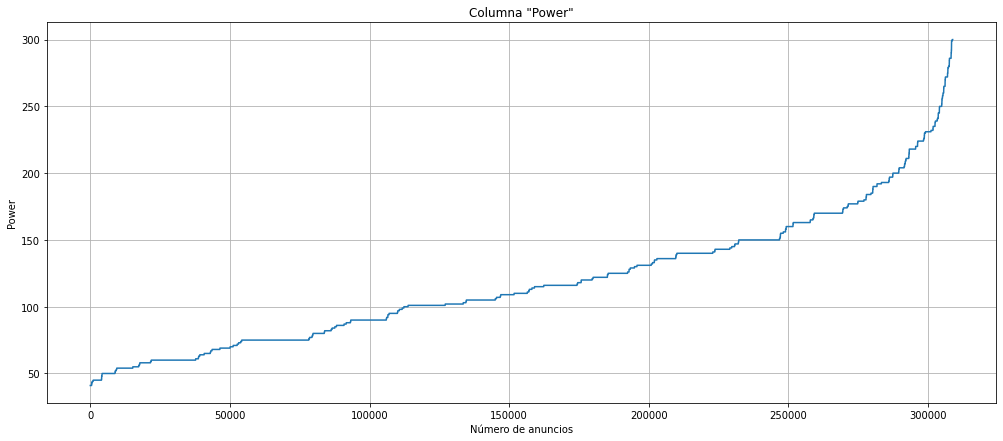

In [12]:
data[(data['Power']<=300) & (data['Power']>40)]['Power'].sort_values(ignore_index=True).plot(figsize=(17,7), grid=True)
plt.title('Columna "Power"')
plt.ylabel('Power')
plt.xlabel('Número de anuncios')
plt.show()

Ahora si tenemos un grupo de datos que se comporta de forma más normal. Aunque continuamos con extremos con comportamiento atípico. Pero se podría llegar a considerar el rango entre 40 y 300 de poder.

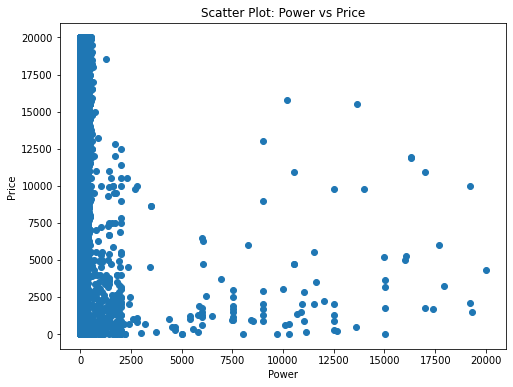

In [13]:
# Eliminar filas con valores NaN en las columnas 'Power' y 'Price'
data_scatter = data.dropna(subset=['Power', 'Price'])

# Crear el scatter plot usando matplotlib
plt.figure(figsize=(8, 6))
plt.scatter(data_scatter['Power'], data_scatter['Price'])
plt.xlabel('Power')
plt.ylabel('Price')
plt.title('Scatter Plot: Power vs Price')
plt.show()


Sin filtrar, tenemos la mayoría de los datos bajo los 2500 de potencia.


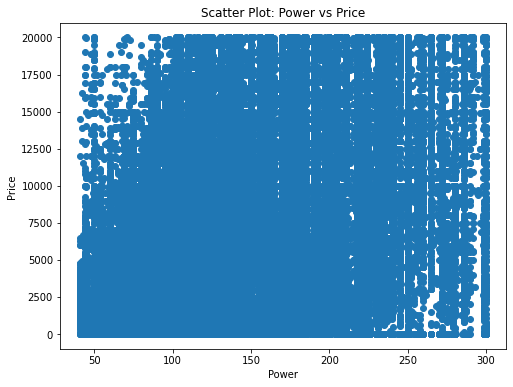

In [14]:
# Filtrar los datos por el rango de potencia deseado
filtered_data = data[(data['Power'] > 40) & (data['Power'] <= 300)]

# Eliminar filas con valores NaN en la columna 'Price'
filtered_data = filtered_data.dropna(subset=['Price'])

# Crear el scatter plot usando matplotlib
plt.figure(figsize=(8, 6))
plt.scatter(filtered_data['Power'], filtered_data['Price'])
plt.xlabel('Power')
plt.ylabel('Price')
plt.title('Scatter Plot: Power vs Price')
plt.show()

Una vez filtrados los datos con potencia sobre 40 y menos e igual a 300, podemos observar que la gran mayoría de los precios de los vehículos se concentra entre las potencias de 40 a 150 en potencia.

#### Veamos la columna `RegistrationYear`:

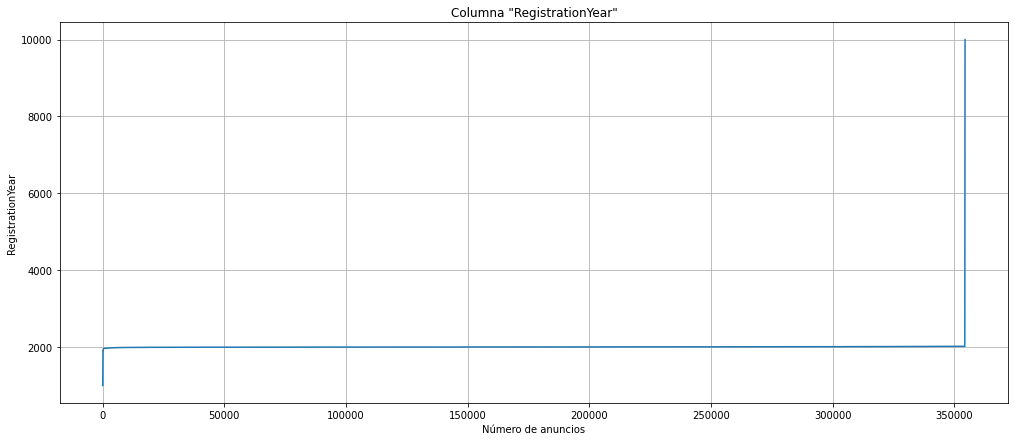

In [15]:
data['RegistrationYear'].sort_values(ignore_index=True).plot(figsize=(17,7), grid=True)
plt.title('Columna "RegistrationYear"')
plt.ylabel('RegistrationYear')
plt.xlabel('Número de anuncios')
plt.show()

Observamos que tenemos vehículos entre el año 1000 y 9999. Tenemos varios valores fuera de un rango razonable. Por ejemplo anuncios de vehículos registrados en el futuro y otros registrados hace más de 100 años. Si bien, estos podrían ser vehículos clásicos. Pero vehículos registrados hace más de 500 años atrás se vuelve menos probable de que sea el año correcto. Cortaremos estos valores y veremos como se distribuye.

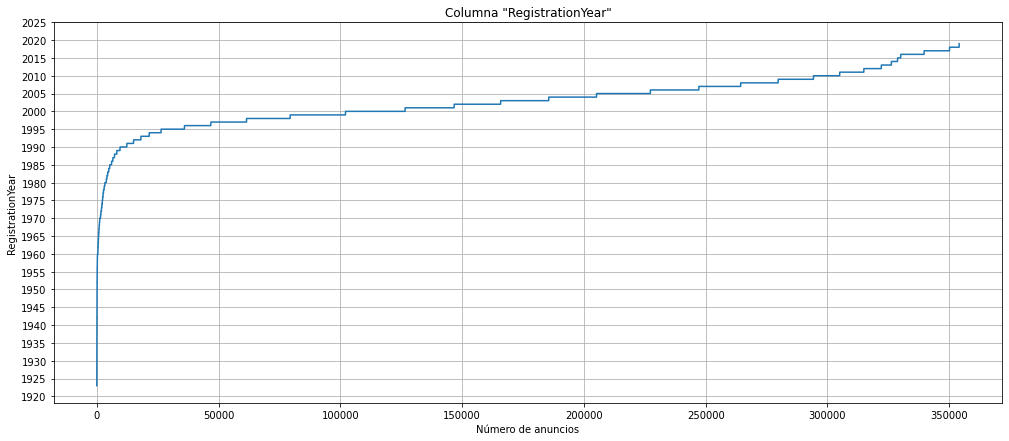

In [16]:
data[(data['RegistrationYear']<=2023) & (data['RegistrationYear']>1920)]['RegistrationYear'].sort_values(ignore_index=True).plot(figsize=(17,7), grid=True)
plt.yticks(np.arange(1920,2030,5))
plt.title('Columna "RegistrationYear"')
plt.ylabel('RegistrationYear')
plt.xlabel('Número de anuncios')
plt.show()

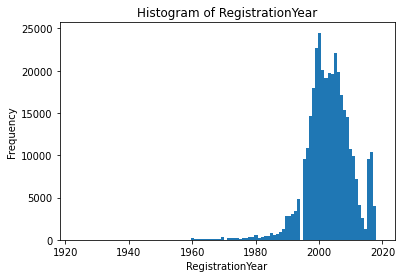

In [17]:
plt.hist(data[(data['RegistrationYear']<=2023) & (data['RegistrationYear']>1920)]['RegistrationYear'].sort_values(ignore_index=True), bins=100)  
plt.xlabel('RegistrationYear')
plt.ylabel('Frequency')
plt.title('Histogram of RegistrationYear')
plt.show()

In [18]:
len(data[(data['RegistrationYear']<=2023) & (data['RegistrationYear']>1990)])/len(data)

0.9645002807807681

Observamos que tenemos un rango más razonable, pero sigue habiendo una gran cantidad de anuncios antiguos. Consideraremos solamente el rango con el comportamiento más estable, siendo los anuncios con registros desde el año 1990 al presente 2023.

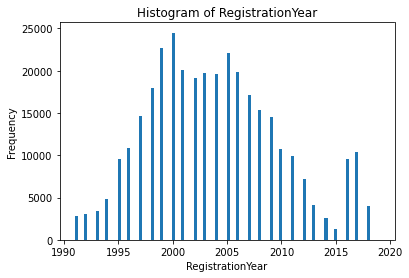

<Figure size 720x648 with 0 Axes>

In [19]:
plt.hist(data[(data['RegistrationYear']<=2023) & (data['RegistrationYear']>1990)]['RegistrationYear'].sort_values(ignore_index=True), bins=100)  
plt.xlabel('RegistrationYear')
plt.ylabel('Frequency')
plt.title('Histogram of RegistrationYear')
plt.figure(figsize=(10,9))
plt.show()

Tomando dichos rangos y representados en el histograma, se ve una cantidad de anuncios más estable.

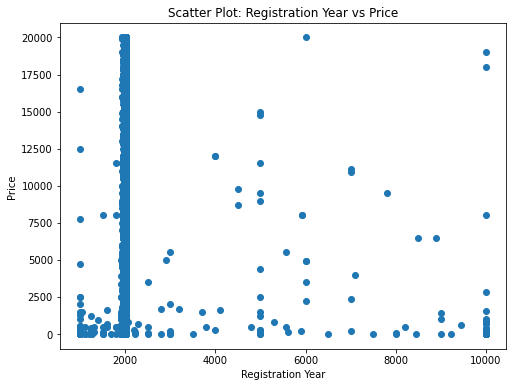

In [20]:
# Eliminar filas con valores NaN en las columnas 'RegistrationYear' y 'Price'
data_scatter = data.dropna(subset=['RegistrationYear', 'Price'])

# Crear el scatter plot usando matplotlib
plt.figure(figsize=(8, 6))
plt.scatter(data_scatter['RegistrationYear'], data_scatter['Price'])
plt.xlabel('Registration Year')
plt.ylabel('Price')
plt.title('Scatter Plot: Registration Year vs Price')
plt.show()



Sin filtrar los datos con los años seleccionamos, observamos que la mayoría de los precios está dentro y antes de los años 2000. Tenemos valores raros a partir del año de registración del 2030.

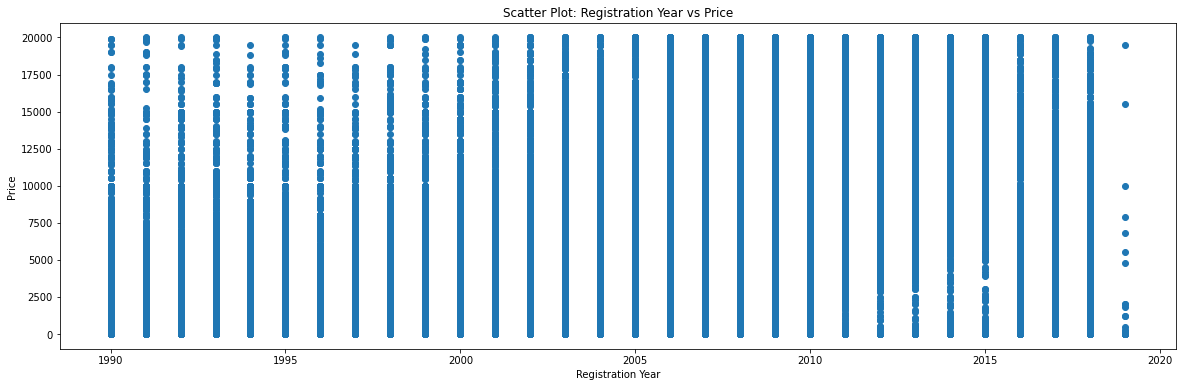

In [21]:
# Filtrar los datos por el rango de años de registro deseado
filtered_data = data[(data['RegistrationYear'] >= 1990) & (data['RegistrationYear'] <= 2023)]

# Eliminar filas con valores NaN en la columna 'Price'
filtered_data = filtered_data.dropna(subset=['Price'])

# Crear el scatter plot usando matplotlib
plt.figure(figsize=(20, 6))
plt.scatter(filtered_data['RegistrationYear'], filtered_data['Price'])
plt.xlabel('Registration Year')
plt.ylabel('Price')
plt.title('Scatter Plot: Registration Year vs Price')
plt.show()

Si filtramos los años de registro de 1990 al 2023, observamos que a partir del año 2001 tenemos más cantidad de vehículos con valores en casi toda la distribución de valores. Antes del año 2000 logramos observamos unos vacíos dentro de valores "normales" y "altos".

#### Veamos la columna `Price`:

In [22]:
data['Price'].sort_values(ignore_index=True).describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

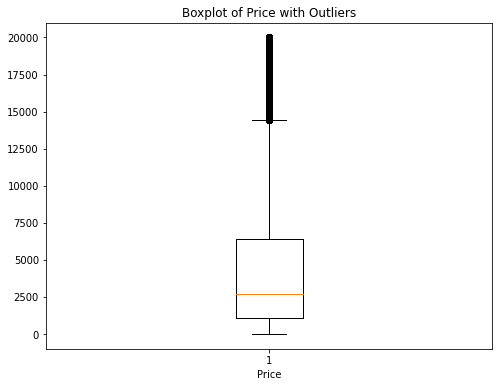

In [23]:
# Calcular el rango intercuartílico (IQR)
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para identificar los datos atípicos
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filtrar los datos atípicos
outliers = data[(data['Price'] < lower_limit) | (data['Price'] > upper_limit)]

# Crear el boxplot 
plt.figure(figsize=(8, 6))
plt.boxplot(data['Price'])
#plt.stripplot(outliers['Price'], color='red', marker='o', size=4)
plt.xlabel('Price')
plt.title('Boxplot of Price with Outliers')
plt.show()

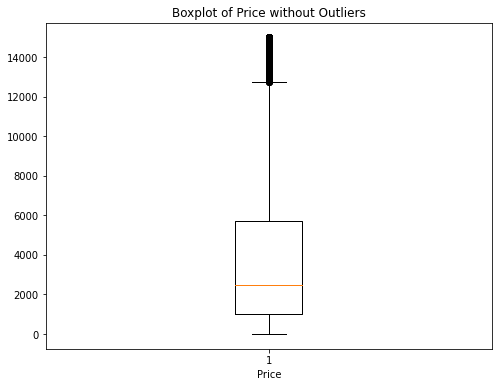

In [24]:
# Definir el umbral para eliminar los valores atípicos
umbral = 15000

# Filtrar los valores atípicos
data_sin_atipicos = data[data['Price'] <= umbral]

# Crear el boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(data_sin_atipicos['Price'])
plt.xlabel('Price')
plt.title('Boxplot of Price without Outliers')
plt.show()

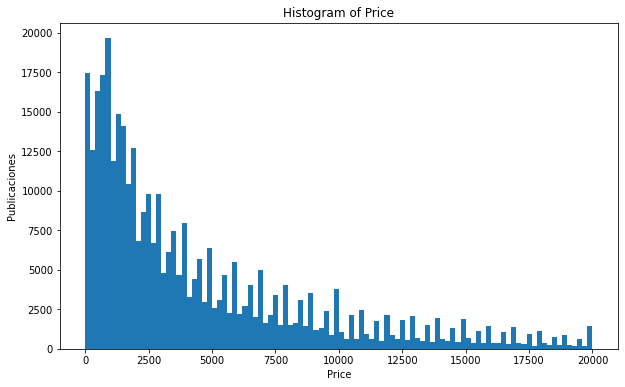

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(data['Price'].sort_values(ignore_index=True), bins=100)  
plt.xlabel('Price')
plt.ylabel('Publicaciones')
plt.title('Histogram of Price')
plt.show()

Observamos que tenemos una gran cantidad de anuncios con valor 0.

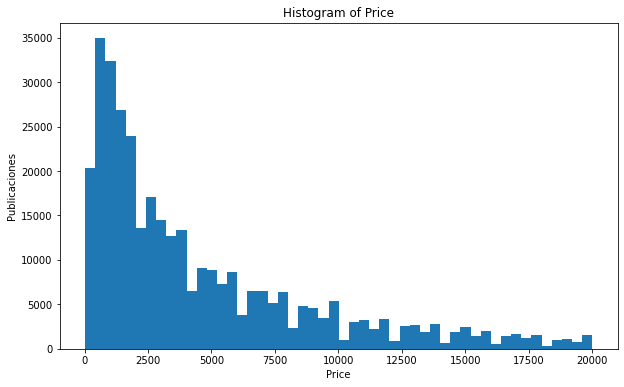

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(data[data['Price']>20]['Price'].sort_values(ignore_index=True), bins=50)  # Puedes ajustar el número de bins según tus necesidades
plt.xlabel('Price')
plt.ylabel('Publicaciones')
plt.title('Histogram of Price')
plt.show()

In [27]:
data[data['Price']>20]['Price'].sort_values(ignore_index=True).describe()

count    342141.000000
mean       4574.493861
std        4514.858527
min          21.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

En la columna `Price`, podemos observar que la gran mayoría o incluso, hasta la mitad de publicaciones tienen valores bajo 2700. Teniendo un salto de valor grande del 50% al 75% y del 75% al valor máximo de 20000. Procedimos a realizar el mismo análisis, pero dejando valores mayor a 20 y obteniendo que hasta el 50% está bajo 2900, teniendo el mismo salto grande de valores del 50% al 75%, manteniéndose el valor máximo de 20000.

#### Matriz de correlación

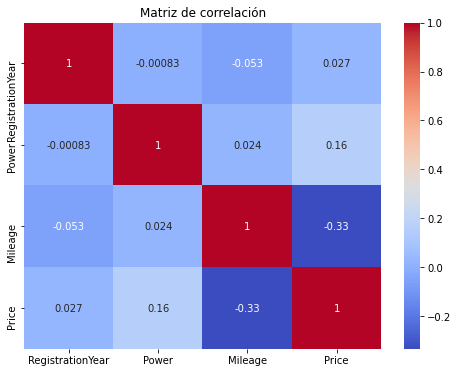

In [28]:
# Seleccionar las columnas de interés
columns = ['RegistrationYear', 'Power', 'Mileage', 'Price']
data_selected = data[columns]

# Eliminar filas con valores NaN
data_selected = data_selected.dropna()

# Calcular la matriz de correlación
correlation_matrix = data_selected.corr()

# Crear el mapa de calor de la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()


Según la Matriz de Correlación, podemos observar lo siguiente:

- No encontramos una correlación perfecta entre ninguna columna con otra.
- Contamos con correlaciones tanto positivas como negativas.
- La correlación entre Power y Price es 0.16 y es muy débil.
- La correlación entre Mileage y Price es de -0.33 y es débil. Que vendría siendo la más alta correlación que tenemos.
- Las otras correlaciones, observamos que están todas en el rango +-0.00 y +-0.09, que sería correlación nula.


#### Columnas categóricas

##### Columna `VehicleType`

In [29]:
data['VehicleType'].value_counts(normalize=True)

sedan          0.288618
small          0.251929
wagon          0.205649
bus            0.090808
convertible    0.063756
coupe          0.051007
suv            0.037857
other          0.010376
Name: VehicleType, dtype: float64

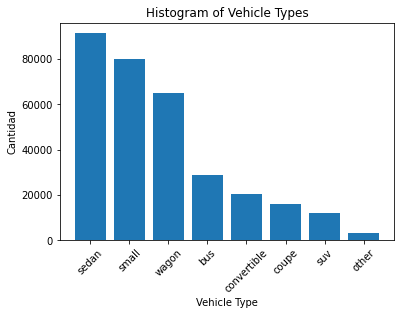

In [30]:
VehicleType_counts = data['VehicleType'].value_counts()
plt.bar(VehicleType_counts.index, VehicleType_counts.values)
plt.xlabel('Vehicle Type')
plt.ylabel('Cantidad')
plt.title('Histogram of Vehicle Types')
plt.xticks(rotation=45)
plt.show()

Observamos que la gran cantidad de tipo de vehiculos son sedan, small y wagon.

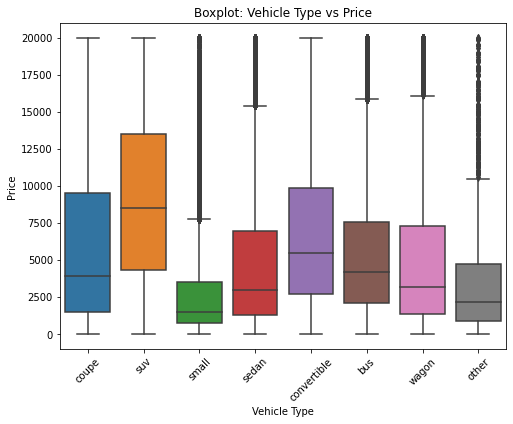

In [31]:
# Crear un nuevo DataFrame con las columnas necesarias
data_boxplot = data[['VehicleType', 'Price']]

# Eliminar filas con valores NaN en las columnas de interés
data_boxplot = data_boxplot.dropna(subset=['VehicleType', 'Price'])

# Crear el boxplot usando seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_boxplot, x='VehicleType', y='Price')
plt.xlabel('Vehicle Type')
plt.ylabel('Price')
plt.title('Boxplot: Vehicle Type vs Price')
plt.xticks(rotation=45)
plt.show()

Observamos que los vehículos SUV son los que tienen el precio más alto dentro de los bigotes, siendo los small con mayor cantidad de valores atípicos. Resaltan los convertibles, que en cantidad de publicación están en 5to puesto, tienen precios  altos también.

##### Columna `Gearbox`

In [32]:
data['Gearbox'].value_counts(normalize=True)

manual    0.80186
auto      0.19814
Name: Gearbox, dtype: float64

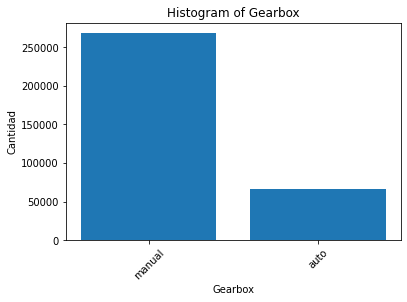

In [33]:
Gearbox_counts = data['Gearbox'].value_counts()
plt.bar(Gearbox_counts.index, Gearbox_counts.values)
plt.xlabel('Gearbox')
plt.ylabel('Cantidad')
plt.title('Histogram of Gearbox')
plt.xticks(rotation=45)
plt.show()

Observamos que la mayoría de los vehículos son manuales.

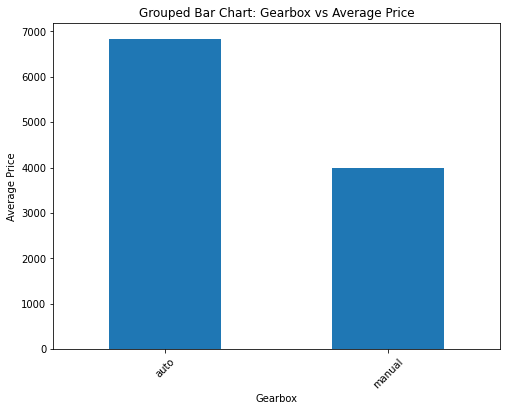

In [34]:
# Agrupar los precios por tipo de transmisión
grouped_data = data.groupby('Gearbox')['Price'].mean()

# Crear el gráfico de barras agrupadas
plt.figure(figsize=(8, 6))
grouped_data.plot(kind='bar')
plt.xlabel('Gearbox')
plt.ylabel('Average Price')
plt.title('Grouped Bar Chart: Gearbox vs Average Price')
plt.xticks(rotation=45)
plt.show()

Si bien, la mayoría de los vehículos publicados son manuales, los vehículos automáticos son más caros en promedio.

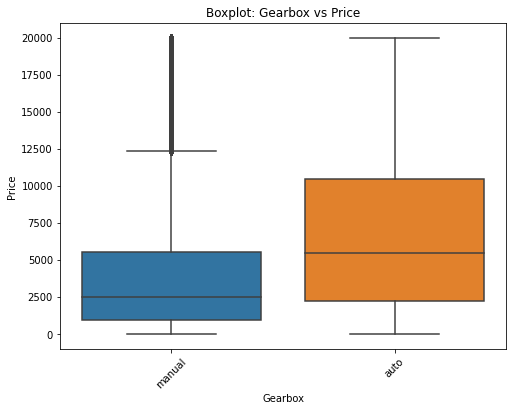

In [35]:
# Crear un nuevo DataFrame con las columnas necesarias
data_boxplot_1 = data[['Gearbox', 'Price']]

# Eliminar filas con valores NaN en las columnas de interés
data_boxplot_1 = data_boxplot_1.dropna(subset=['Gearbox', 'Price'])

# Crear el boxplot usando seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_boxplot_1, x='Gearbox', y='Price')
plt.xlabel('Gearbox')
plt.ylabel('Price')
plt.title('Boxplot: Gearbox vs Price')
plt.xticks(rotation=45)
plt.show()

Como en el gráfico anterior, ratificamos que los vehículos automáticos son más caros, comparado con los de caja manual.

##### Columna `Model`

In [36]:
data['Model'].value_counts(normalize=True)

golf                  0.087347
other                 0.072972
3er                   0.059047
polo                  0.039042
corsa                 0.037560
                        ...   
serie_2               0.000024
serie_3               0.000012
rangerover            0.000012
serie_1               0.000006
range_rover_evoque    0.000006
Name: Model, Length: 250, dtype: float64

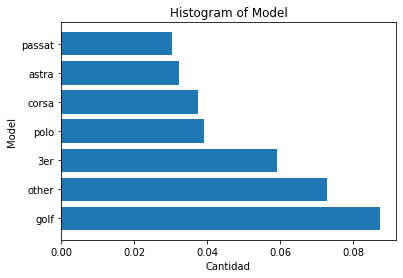

<Figure size 720x1080 with 0 Axes>

In [37]:
Model_counts = data['Model'].value_counts(normalize=True)
top_models = Model_counts[Model_counts >= 0.03]
plt.barh(top_models.index, top_models.values)
plt.xlabel('Cantidad')
plt.ylabel('Model')
plt.title('Histogram of Model')
plt.figure(figsize=(10,15))
#plt.xticks(rotation=90)
plt.show()

In [38]:
data['Model'].value_counts().describe()

count      250.000000
mean      1338.656000
std       3277.262009
min          2.000000
25%        145.250000
50%        369.000000
75%        888.750000
max      29232.000000
Name: Model, dtype: float64

<AxesSubplot:>

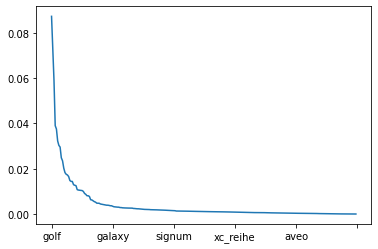

In [39]:
data['Model'].value_counts(normalize=True).plot()

Tenemos 250 modelos diferentes. La cantidad de anuncios por modelo es bastante baja. De todas formas, apreciamos que los modelos más publicados, a menos de "otros", son de marca Europea, marca VW y OPEL, para ser más detallados. Que a su vez, se ratifica más adelante como las marcas más publicadas también.

Por tener una gran cantidad de modelos diferentes dentro de esta columna, codificarla para que los modelos puedan procesarla será un problema. Además hará que los modelos tomarán mucho tiempo de proceso y podría influir en sus predicciones de forma desproporcionada al tener tantas diferencias entre las cantidades de anuncios por modelo. Tal vez es mejor eliminar esta columna.

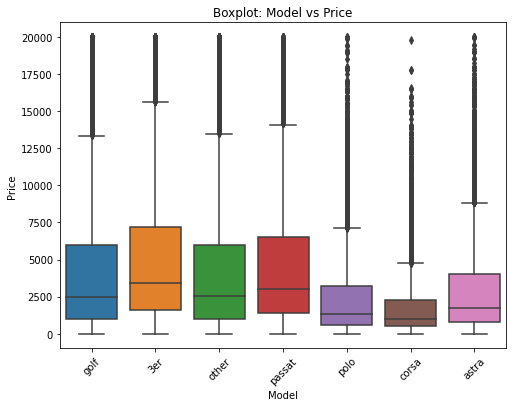

In [40]:
# Filtrar los modelos que cumplen con la frecuencia relativa mínima
filtered_models = top_models.index

# Crear un nuevo DataFrame con los modelos filtrados y los precios correspondientes
data_filtered = data[data['Model'].isin(filtered_models)][['Model', 'Price']]

# Eliminar filas con valores NaN en la columna de precios
data_filtered = data_filtered.dropna(subset=['Price'])

# Crear el boxplot usando seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_filtered, x='Model', y='Price')
plt.xlabel('Model')
plt.ylabel('Price')
plt.title('Boxplot: Model vs Price')
plt.xticks(rotation=45)
plt.show()

Al observar los modelos comparado con el precio, observamos que el modelo Golf, siendo el más publicado, no es el con mayor rango de valor. Este viene siendo el '3er', que a su vez es el tercer modelo más publicado. Sopresivamente, el Passat está dentro de los valores más altos, siendo el menos publicado dentro de nuestro filtro.

##### Columna `FuelType`

In [41]:
data['FuelType'].value_counts(normalize=True)

petrol      0.673000
gasoline    0.307085
lpg         0.016518
cng         0.001758
hybrid      0.000725
other       0.000635
electric    0.000280
Name: FuelType, dtype: float64

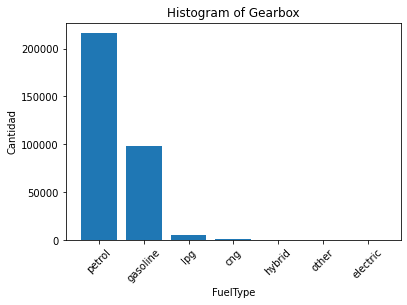

In [42]:
FuelType_counts = data['FuelType'].value_counts()
plt.bar(FuelType_counts.index, FuelType_counts.values)
plt.xlabel('FuelType')
plt.ylabel('Cantidad')
plt.title('Histogram of Gearbox')
plt.xticks(rotation=45)
plt.show()

Si bien, ya estamos en la época de vehículos eléctricos, seguimos observando mayor cantidad de vehículos con combustión interna. Al igual que en la columna `VehicleType`, llenaremos los datos vacíos de esta columna con la categoría 'other'.

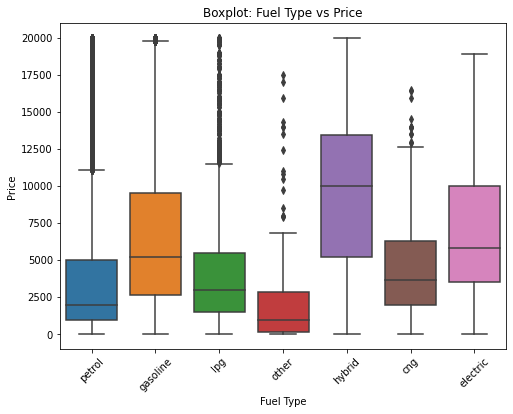

In [43]:
# Crear un nuevo DataFrame con las columnas necesarias
FuelType_boxplot = data[['FuelType', 'Price']]

# Eliminar filas con valores NaN en las columnas de interés
FuelType_boxplot = FuelType_boxplot.dropna(subset=['FuelType', 'Price'])

# Crear el boxplot usando seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=FuelType_boxplot, x='FuelType', y='Price')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.title('Boxplot: Fuel Type vs Price')
plt.xticks(rotation=45)
plt.show()

Sorpresivamente, los vehículos con tipo de "combustible" más caros son los híbridos, seguidos por los eléctricos y gasolina. Si bien, podría ser lógico, porque los vehículos híbridos de 0Km, son bastante caros. Pero al parecer no tienen un desavaluo tan grande como los otros tipos de "combustibles". En cambio, los vehículos a petroleo que son los más publicados, tienen valores bajos.

##### Columna `Brand`

In [44]:
data['Brand'].value_counts()

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

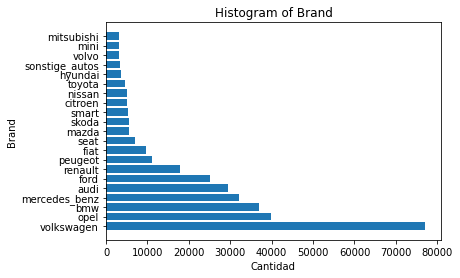

<Figure size 720x1080 with 0 Axes>

In [45]:
Brand_counts = data['Brand'].value_counts()
top_brands = Brand_counts[Brand_counts >= 3000]
plt.barh(top_brands.index, top_brands.values)
plt.xlabel('Cantidad')
plt.ylabel('Brand')
plt.title('Histogram of Brand')
plt.figure(figsize=(10,15))
#plt.xticks(rotation=45)
plt.show()

Se observa que la gran mayoría de las marcas publicadas, son Europeas, menos Ford que se cuela entremedio del top 10. Siendo Mazda la marca Japonesa más publicada.

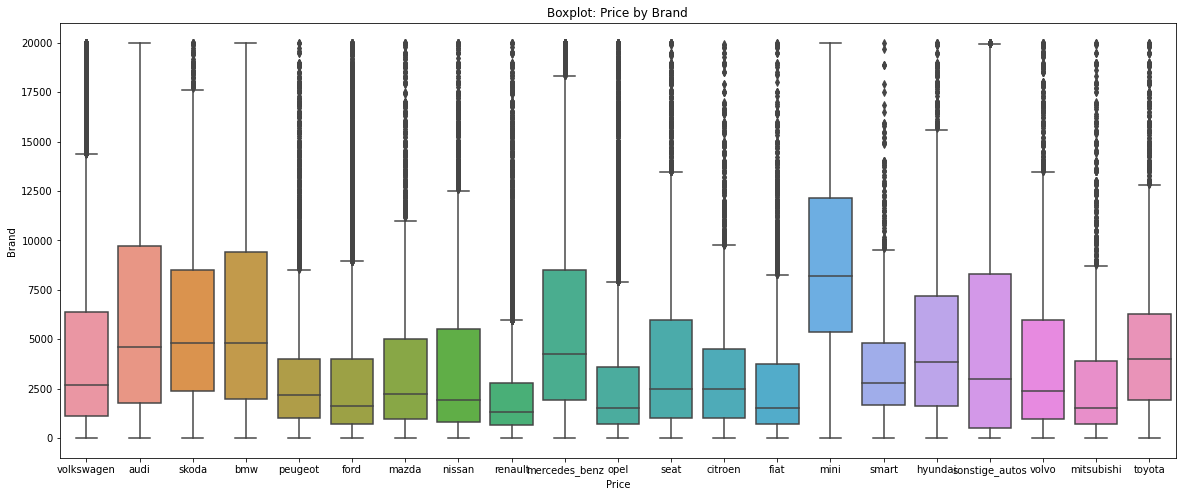

In [46]:
# Obtener el recuento de marcas de vehículos
brand_counts = data['Brand'].value_counts()

# Definir el umbral de frecuencia mínima
umbral = 3000

# Filtrar las marcas que cumplen con el umbral de frecuencia mínima
filtered_brands = brand_counts[brand_counts >= umbral].index

# Crear un nuevo DataFrame con las marcas de vehículos filtradas y los precios correspondientes
data_filtered = data[data['Brand'].isin(filtered_brands)][['Brand', 'Price']]

# Eliminar filas con valores NaN en la columna de precios
data_filtered = data_filtered.dropna(subset=['Price'])

# Crear el boxplot usando seaborn
plt.figure(figsize=(20, 8))
sns.boxplot(data=data_filtered, y='Price', x='Brand')
plt.ylabel('Brand')
plt.xlabel('Price')
plt.title('Boxplot: Price by Brand')
plt.show()


Mini se destaca por ser la marca más cara dentro de los datos filtrados. Seguido por Audi, BMW y Mercedes Benz que hace un poco de lógica. Y la marca Volkswagen, que es la más publicada, está dentro de los vehículos de valor "normal".


##### Columna `NotRepaired`

In [47]:
data['NotRepaired'].value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

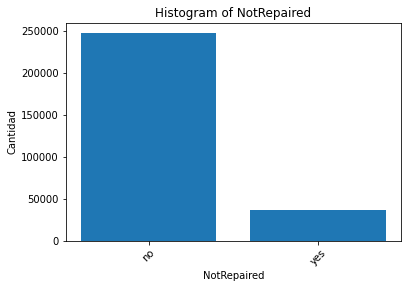

In [48]:
NotRepaired_counts = data['NotRepaired'].value_counts()
plt.bar(NotRepaired_counts.index, NotRepaired_counts.values)
plt.xlabel('NotRepaired')
plt.ylabel('Cantidad')
plt.title('Histogram of NotRepaired')
plt.xticks(rotation=45)
plt.show()

Esta columna, es la que tiene la mayor cantidad de datos faltantes. Si vemos la mayoría de datos existentes, podemos llegar a la conclusión de que llenaremos los datos vacíos con la categoría "no". También cabe mencionar, que esta columna es fácil de codificarse, sin necesidad de crear nuevas columnas.

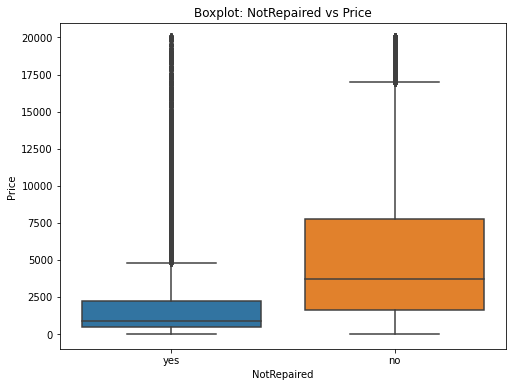

In [49]:
# Eliminar filas con valores NaN en las columnas 'NotRepaired' y 'Price'
NotRepaired_boxplot = data.dropna(subset=['NotRepaired', 'Price'])

# Crear el boxplot usando seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(data=NotRepaired_boxplot, x='NotRepaired', y='Price')
plt.xlabel('NotRepaired')
plt.ylabel('Price')
plt.title('Boxplot: NotRepaired vs Price')
plt.show()



Observamos que los vehículos No reparados, tienen mayor valor, que es lógico. Porque un vehículo usado no reparado tiene mejor avalúo.

## Preparación de datos

Antes de alterar el DataFrame, crearemos una copia por si necesitaremos hacer comparaciones.

In [50]:
data_raw = data.copy()

#### Eliminación de columnas

Los modelos podrán tener problemas con las columnas de fechas, PostalCode y Model. Confundirán a los modelos. Por lo tanto eliminaremos todas estas columnas.

In [51]:
#Eliminaremos las columnas
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures'], axis=1)

In [52]:
#Comprobamos como queda el DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Mileage            354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  NotRepaired        283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


#### Limpieza de datos atípicos

Apliquemos los límites encontrados en la exploración de datos

In [53]:
data = data[(data['Power']<=300) & (data['Power']>=40)]
data = data[(data['RegistrationYear']<=2023) & (data['RegistrationYear']>=1990)]

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302760 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              302760 non-null  int64 
 1   VehicleType        280532 non-null  object
 2   RegistrationYear   302760 non-null  int64 
 3   Gearbox            296626 non-null  object
 4   Power              302760 non-null  int64 
 5   Model              290821 non-null  object
 6   Mileage            302760 non-null  int64 
 7   RegistrationMonth  302760 non-null  int64 
 8   FuelType           282432 non-null  object
 9   Brand              302760 non-null  object
 10  NotRepaired        255375 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.7+ MB


Como anteriormente mencionado, observamos que los datos vacíos correspondían a los anuncios fuera de rangos normales.

#### Llenado de datos vacíos

In [55]:
data['VehicleType'].fillna(value='other', axis=0, inplace=True)
data['FuelType'].fillna(value='other', axis=0, inplace=True)
data['Gearbox'].fillna(value='manual', axis=0, inplace=True)
data['NotRepaired'].fillna(value='no', axis=0, inplace=True)
data['Model'].fillna(value='unknown', axis=0, inplace=True)

In [56]:
#Comprobamos como quedó el DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302760 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              302760 non-null  int64 
 1   VehicleType        302760 non-null  object
 2   RegistrationYear   302760 non-null  int64 
 3   Gearbox            302760 non-null  object
 4   Power              302760 non-null  int64 
 5   Model              302760 non-null  object
 6   Mileage            302760 non-null  int64 
 7   RegistrationMonth  302760 non-null  int64 
 8   FuelType           302760 non-null  object
 9   Brand              302760 non-null  object
 10  NotRepaired        302760 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.7+ MB


#### Columnas `str`:

Codifiquemos las columnas con datos de tipo `str`, para que los modelos no tengan problemas:

In [57]:
data_1 = data.copy()

#Apliquemos el método OrdinalEnconder
enc = OrdinalEncoder()
data_enc = data_1.copy()
data_enc[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox', 'Model', 'Brand']] = enc.fit_transform(data_1[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox', 'Model', 'Brand']])
#data_enc[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox']] = enc.fit_transform(data_1[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox']])

#Eliminamos las columnas Model y Brand por su gran cantidad de variables
data_1 = data.drop(['Model','Brand'], axis=1)

#Creamos las variables dummies, excepto por las columnas las columnas eliminadas
data_ohe = pd.get_dummies(data_1, drop_first=True)

#Veamos como queda el set de datos
data_ohe.shape


(302760, 20)

#### Features y Targets

In [58]:
#Fijamos una semilla
rs = RandomState(54321)

Separamos los datos codificados con OrdinalEnconder:

In [59]:
#Separación de datos para la validación
rest_enc, valid = train_test_split(data_enc, test_size=0.20, random_state=rs)

#Separación de datos para entrenamiento y testeo
train, test = train_test_split(rest_enc, test_size=0.25, random_state=rs)

#Creación de features y targets para entrenamiento
features_train_enc = train.drop('Price', axis=1)
targets_train_enc = train['Price']

#Creación de features y targets para testeo
features_test_enc = test.drop('Price', axis=1)
targets_test_enc = test['Price']

#Creación de features y targets para validación
features_valid_enc = valid.drop('Price', axis=1)
targets_valid_enc = valid['Price']

#Comprobemos el tamaño de los sets
print("Conjunto entrenamiento:")
print(features_train_enc.shape)
print(targets_train_enc.shape)
print()
print("Conjunto de testeo:")
print(features_test_enc.shape)
print(targets_test_enc.shape)
print()
print("Conjunto de validación:")
print(features_valid_enc.shape)
print(targets_valid_enc.shape)

Conjunto entrenamiento:
(181656, 10)
(181656,)

Conjunto de testeo:
(60552, 10)
(60552,)

Conjunto de validación:
(60552, 10)
(60552,)


#### Separaremos los datos con OHE:

In [60]:
#Separamos los datos para la validación
rest_ohe, valid = train_test_split(data_ohe, test_size=0.20, random_state=rs)

#Separamos los datos de entrenamiento y testeo
train, test = train_test_split(rest_ohe, test_size=0.25, random_state=rs)

#Creamos features y targets para entrenamiento
features_train_ohe = train.drop('Price', axis=1)
targets_train_ohe = train['Price']

#Creamos features y targets para testeo
features_test_ohe = test.drop('Price', axis=1)
targets_test_ohe = test['Price']

#Creamos features y targets para validación
features_valid_ohe = valid.drop('Price', axis=1)
targets_valid_ohe = valid['Price']

#Creamos features y targets para el entrenamiento de validación
features_rest_ohe = rest_ohe.drop('Price', axis=1)
targets_rest_ohe = rest_ohe['Price']

#Comprobemos el tamaño de los sets
print("Conjunto entrenamiento:")
print(features_train_ohe.shape)
print(targets_train_ohe.shape)
print()
print("Conjunto de testeo:")
print(features_test_ohe.shape)
print(targets_test_ohe.shape)
print()
print("Conjunto de validación:")
print(features_valid_ohe.shape)
print(targets_valid_ohe.shape)

Conjunto entrenamiento:
(181656, 19)
(181656,)

Conjunto de testeo:
(60552, 19)
(60552,)

Conjunto de validación:
(60552, 19)
(60552,)


#### Separamos los datos no codificados:

In [61]:
#Separamos los datos para la validación
rest, valid = train_test_split(data, test_size=0.20, random_state=rs)

#Separamos los datos para entrenamiento y testeo
train, test = train_test_split(rest, test_size=0.25, random_state=rs)

#Creamos features y targets para entrenamiento
features_train = train.drop('Price', axis=1)
targets_train = train['Price']

#Creamos features y targets para testeo
features_test = test.drop('Price', axis=1)
targets_test = test['Price']

#Creamos features y targets para validación
features_valid = valid.drop('Price', axis=1)
targets_valid = valid['Price']

#Creamos features y targets para el entrenamiento de la validación
features_rest = rest.drop('Price', axis=1)
targets_rest = rest['Price']

#Comprobemos el tamaño de los sets
print("Conjunto entrenamiento:")
print(features_train.shape)
print(targets_train.shape)
print()
print("Conjunto de testeo:")
print(features_test.shape)
print(targets_test.shape)
print()
print("Conjunto de validación:")
print(features_valid.shape)
print(targets_valid.shape)

Conjunto entrenamiento:
(181656, 10)
(181656,)

Conjunto de testeo:
(60552, 10)
(60552,)

Conjunto de validación:
(60552, 10)
(60552,)


## Entrenamiento del modelo 

### Prueba de cordura con regresión lineal

In [62]:
reg = LinearRegression()
print('Tiempo de entrenamiento:')
%time reg.fit(features_train_ohe, targets_train_ohe)
print()
print('Tiempo de predicción:')
%time reg_pred_ohe = reg.predict(features_valid_ohe)
print()
print('RECM: ')
print(mean_squared_error(targets_valid_ohe, reg_pred_ohe, squared=False))

Tiempo de entrenamiento:
CPU times: user 128 ms, sys: 106 ms, total: 234 ms
Wall time: 188 ms

Tiempo de predicción:
CPU times: user 11.6 ms, sys: 11 ms, total: 22.6 ms
Wall time: 80.2 ms

RECM: 
2662.372294314971


### Bosque aleatorio con ajuste de hiperparámetros

In [63]:
# score = max(data['Price'])
# n=1
# for roots in range(3,8):
#     for leafs in range(3,8):
#         print('Round', n)
#         forest = RandomForestRegressor(random_state=rs, max_depth=roots, min_samples_leaf=leafs)
#         print('Tiempo de entrenamiento:')
#         %time forest.fit(features_train_enc, targets_train_enc)
#         print('Tiempo de predicción:')
#         %time f_pred = forest.predict(features_valid_enc)
#         sco = mean_squared_error(targets_valid_enc, f_pred, squared=False)
#         print('RECM:', sco)
#         print()
#         if sco < score:
#             score = sco
#             best_root = roots
#             best_leaf = leafs
#             best_pred = f_pred
#             best_n = n
#         n += 1
        
# best_forest = RandomForestRegressor(random_state = rs, max_depth = best_root, min_samples_leaf = best_leaf)
# print()
# print('Mejor round:', best_n)
# print('Mejor RECM:', score)

In [64]:
# # Definir los rangos de los hiperparámetros a probar
# param_dist = {
#     'max_depth': sp_randint(3, 8),
#     'min_samples_leaf': sp_randint(2, 8)
# }

# # Crear el modelo de Bosque Aleatorio
# model = RandomForestRegressor(random_state=rs)

# # Crear el objeto RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5, scoring=make_scorer(mean_squared_error, squared=False))

# # Realizar la búsqueda aleatoria
# random_search.fit(features_train_enc, targets_train_enc)

# # Obtener los mejores hiperparámetros y el mejor score
# best_params = random_search.best_params_
# best_score = random_search.best_score_

# # Imprimir los mejores hiperparámetros y el mejor score
# print('Mejores hiperparámetros:', best_params)
# print('Mejor RECM:', best_score)



In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Definir los hiperparámetros a probar
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_leaf': [3, 4, 5, 6, 7]
}

# Crear el modelo de Bosque Aleatorio
model = RandomForestRegressor(random_state=rs)

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=make_scorer(mean_squared_error, squared=False))

# Definir una función para realizar la búsqueda de hiperparámetros
def run_grid_search():
    grid_search.fit(features_train_enc, targets_train_enc)

# Medir el tiempo de ejecución utilizando %time
%time run_grid_search()

# Obtener los mejores hiperparámetros y el mejor score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Imprimir los mejores hiperparámetros y el mejor score
print('Mejores hiperparámetros:', best_params)
print('Mejor RECM:', best_score)

CPU times: user 31min 33s, sys: 797 ms, total: 31min 34s
Wall time: 31min 35s
Mejores hiperparámetros: {'max_depth': 3, 'min_samples_leaf': 3}
Mejor RECM: 2855.5231414933924


In [66]:
# Utilizar los mejores hiperparámetros en el modelo
best_forest = RandomForestRegressor(random_state=rs, max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'])

# Entrenar el modelo con los mejores hiperparámetros
print('Tiempo de entrenamiento:')
%time best_forest.fit(features_train_enc, targets_train_enc)

# Realizar predicciones utilizando el modelo entrenado
print('Tiempo de predicción:')
%time f_pred = best_forest.predict(features_valid_enc)

# Calcular el score final
score = mean_squared_error(targets_valid_enc, f_pred, squared=False)

print()
print('Mejor RECM:', score)

Tiempo de entrenamiento:
CPU times: user 11.9 s, sys: 7.98 ms, total: 11.9 s
Wall time: 11.9 s
Tiempo de predicción:
CPU times: user 182 ms, sys: 0 ns, total: 182 ms
Wall time: 182 ms

Mejor RECM: 2842.757068515389


In [82]:
tiempo_entrenamiento_bosque = %timeit -n1 -r1 -o best_forest.fit(features_train_enc, targets_train_enc)
tiempo_predicción_bosque = %timeit -n1 -r1 -o best_forest.predict(features_valid_enc) 
error_test_bosque = mean_squared_error(targets_valid_enc, f_pred, squared=False)

14 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
195 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [83]:
#Creamos una lista vacía para poder juntar todos los modelos en dicha lista
resultados_modelos = []
#Agregamos los resultados en nuestra lista vacía
resultados_modelos.append({
    'modelo' : 'RandomForestRegressor',
    'tiempo de entrenamiento' : tiempo_entrenamiento_bosque,
    'tiempo de predicción' : tiempo_predicción_bosque,
    'error de test' : error_test_bosque    
})

Observamos que el RECM va a la baja. Vamos por buen camino.

### CatBoost

In [85]:
cat = CatBoostRegressor(iterations=200, cat_features=['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand'], silent=True)
print('Tiempo de entrenamiento:')
%time cat.fit(features_train, targets_train, eval_set=(features_valid, targets_valid))
print()
print('Tiempo de predicción:')
%time cat_pred = cat.predict(features_valid)
print(mean_squared_error(targets_valid, cat_pred, squared=False))

Tiempo de entrenamiento:
CPU times: user 54.1 s, sys: 72 ms, total: 54.1 s
Wall time: 54.5 s

Tiempo de predicción:
CPU times: user 171 ms, sys: 0 ns, total: 171 ms
Wall time: 171 ms
1628.6893605242037


In [86]:
tiempo_modelo_catboost = %timeit -n1 -r1 -o cat.fit(features_train, targets_train, eval_set=(features_valid, targets_valid))
tiempo_predicción_catboost = %timeit -n1 -r1 -o cat.predict(features_valid)
error_catboost = mean_squared_error(targets_valid, cat_pred, squared=False)

53.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
171 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [87]:
resultados_modelos.append({
    'modelo' : 'Regresion CATBoost',
    'tiempo de entrenamiento' : tiempo_modelo_catboost,
    'tiempo de predicción' : tiempo_predicción_catboost,
    'error de test' : error_catboost
})

Al aplicar modelo de potenciación de gradiente, logramos obtener resultados mucho mejores que con los 2 modelos anteriores. Además, el tiempo de demora en ejecutarse es menor que el tiempo total que se demora el bosque aleatorio. Por el momento, este es nuestra mejor opción.

### LightGBM con ajuste de hiperparámetros

Antes de poder aplicar este modelo, debemos cambiar el tipo de datos a columnas categóricas.

In [89]:
features_train[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand']]= features_train[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand']].astype('category')
features_valid[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand']]= features_valid[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand']].astype('category')
features_test[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand']]= features_test[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand']].astype('category')
features_rest[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand']]= features_rest[['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand']].astype('category')

Ahora podemos crear, entrenar y aplicar el modelo LightGBM.

In [90]:
lgbm = lgb.LGBMRegressor(random_state = rs)
print('Tiempo de entrenamiento:')
%time lgbm.fit(features_train, targets_train, eval_metric = 'RMSE', categorical_feature=['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand'], eval_set=(features_valid, targets_valid))
print()
print('Tiempo de predicción:')
%time lgbm_pred = lgbm.predict(features_valid)
print(mean_squared_error(targets_valid, lgbm_pred, squared=False))

Tiempo de entrenamiento:


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 4180.11	valid_0's l2: 1.74733e+07
[2]	valid_0's rmse: 3886.96	valid_0's l2: 1.51084e+07
[3]	valid_0's rmse: 3629.22	valid_0's l2: 1.31712e+07
[4]	valid_0's rmse: 3402.73	valid_0's l2: 1.15786e+07
[5]	valid_0's rmse: 3199.49	valid_0's l2: 1.02368e+07
[6]	valid_0's rmse: 3021.25	valid_0's l2: 9.12793e+06
[7]	valid_0's rmse: 2865.32	valid_0's l2: 8.21005e+06
[8]	valid_0's rmse: 2723.8	valid_0's l2: 7.41907e+06
[9]	valid_0's rmse: 2600.01	valid_0's l2: 6.76006e+06
[10]	valid_0's rmse: 2491.92	valid_0's l2: 6.20968e+06
[11]	valid_0's rmse: 2397.19	valid_0's l2: 5.74651e+06
[12]	valid_0's rmse: 2312.48	valid_0's l2: 5.34755e+06
[13]	valid_0's rmse: 2238.05	valid_0's l2: 5.00885e+06
[14]	valid_0's rmse: 2172.63	valid_0's l2: 4.72031e+06
[15]	valid_0's rmse: 2114.32	valid_0's l2: 4.47037e+06
[16]	valid_0's rmse: 2065.64	valid_0's l2: 4.26686e+06
[17]	valid_0's rmse: 2021.57	valid_0's l2: 4.08673e+06
[18]	valid_0's rmse: 1981.9	valid_0's l2: 3.92791e+06
[19]	valid_0's rmse: 

Podemos observar que el error es el más bajo y el tiempo de ejecución disminuyó bastante también. Podríamos decir que hemos encontrado el mejor modelo.

In [91]:
tiempo_modelo_lightgbm = %timeit -n1 -r1 -o lgbm.fit(features_train, targets_train, eval_metric = 'RMSE', categorical_feature=['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand'], eval_set=(features_valid, targets_valid))
tiempo_predicción_lightgbm = %timeit -n1 -r1 -o lgbm.predict(features_valid)
error_lightgbm = mean_squared_error(targets_valid, lgbm_pred, squared=False)



/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 4180.11	valid_0's l2: 1.74733e+07
[2]	valid_0's rmse: 3886.96	valid_0's l2: 1.51084e+07
[3]	valid_0's rmse: 3629.22	valid_0's l2: 1.31712e+07
[4]	valid_0's rmse: 3402.73	valid_0's l2: 1.15786e+07
[5]	valid_0's rmse: 3199.49	valid_0's l2: 1.02368e+07
[6]	valid_0's rmse: 3021.25	valid_0's l2: 9.12793e+06
[7]	valid_0's rmse: 2865.32	valid_0's l2: 8.21005e+06
[8]	valid_0's rmse: 2723.8	valid_0's l2: 7.41907e+06
[9]	valid_0's rmse: 2600.01	valid_0's l2: 6.76006e+06
[10]	valid_0's rmse: 2491.92	valid_0's l2: 6.20968e+06
[11]	valid_0's rmse: 2397.19	valid_0's l2: 5.74651e+06
[12]	valid_0's rmse: 2312.48	valid_0's l2: 5.34755e+06
[13]	valid_0's rmse: 2238.05	valid_0's l2: 5.00885e+06
[14]	valid_0's rmse: 2172.63	valid_0's l2: 4.72031e+06
[15]	valid_0's rmse: 2114.32	valid_0's l2: 4.47037e+06
[16]	valid_0's rmse: 2065.64	valid_0's l2: 4.26686e+06
[17]	valid_0's rmse: 2021.57	valid_0's l2: 4.08673e+06
[18]	valid_0's rmse: 1981.9	valid_0's l2: 3.92791e+06
[19]	valid_0's rmse: 

In [92]:
resultados_modelos.append({
    'modelo' : 'Regresion LGBMRegressor',
    'tiempo de entrenamiento' : tiempo_modelo_lightgbm,
    'tiempo de predicción' : tiempo_predicción_lightgbm,
    'error de test' : error_lightgbm
})

## Análisis del modelo

Ya aplicado todos los modelos, pudimos observar una mejora en los valores de los errores. Concluyendo que los resultados más bajos, los arrojan los modelos `CatBoost`y `LightGBM`. Habiendo una pequeña diferencia entre ellos.

Una diferencia a tomar en cuenta también, es el tiempo que toma cada uno de los modelos, en la ejecución de su entrenamiento y predicción. Entre estos dos últimos modelos, el `LightGBM`se demora considerablemente menos que el `CatBoost`.



Antes que terminemos, entrenaremos el modelo `LightGBM`con nuestro DF restantes y haremos el último testeo. Debiésemos obtener resultados similares a los obtenidos anteriormente.

In [94]:
lgbm = lgb.LGBMRegressor(random_state=rs)
print('Tiempo de entrenamiento:')
%time lgbm.fit(features_rest, targets_rest, eval_metric = 'RMSE', categorical_feature=['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand'], eval_set=(features_test, targets_test))
print()
print('Tiempo de predicción:')
%time lgbm_pred = lgbm.predict(features_test)
print(mean_squared_error(targets_test, lgbm_pred, squared=False))

Tiempo de entrenamiento:


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 4172.57	valid_0's l2: 1.74103e+07
[2]	valid_0's rmse: 3879.05	valid_0's l2: 1.50471e+07
[3]	valid_0's rmse: 3622.42	valid_0's l2: 1.31219e+07
[4]	valid_0's rmse: 3392.08	valid_0's l2: 1.15062e+07
[5]	valid_0's rmse: 3189.98	valid_0's l2: 1.0176e+07
[6]	valid_0's rmse: 3011.64	valid_0's l2: 9.06995e+06
[7]	valid_0's rmse: 2855.61	valid_0's l2: 8.15449e+06
[8]	valid_0's rmse: 2719.13	valid_0's l2: 7.39369e+06
[9]	valid_0's rmse: 2594.84	valid_0's l2: 6.7332e+06
[10]	valid_0's rmse: 2485.1	valid_0's l2: 6.1757e+06
[11]	valid_0's rmse: 2388.67	valid_0's l2: 5.70575e+06
[12]	valid_0's rmse: 2303.92	valid_0's l2: 5.30805e+06
[13]	valid_0's rmse: 2230	valid_0's l2: 4.97288e+06
[14]	valid_0's rmse: 2165.38	valid_0's l2: 4.68888e+06
[15]	valid_0's rmse: 2109.41	valid_0's l2: 4.44961e+06
[16]	valid_0's rmse: 2058.95	valid_0's l2: 4.23927e+06
[17]	valid_0's rmse: 2015.58	valid_0's l2: 4.06255e+06
[18]	valid_0's rmse: 1976.26	valid_0's l2: 3.90559e+06
[19]	valid_0's rmse: 1940.

In [98]:
tiempo_modelo_lightgbm_test = %timeit -n1 -r1 -o lgbm.fit(features_rest, targets_rest, eval_metric = 'RMSE', categorical_feature=['VehicleType', 'FuelType', 'NotRepaired', 'Gearbox' , 'Model', 'Brand'], eval_set=(features_test, targets_test))
tiempo_predicción_lightgbm_test = %timeit -n1 -r1 -o lgbm.predict(features_test)
error_lightgbm_test = mean_squared_error(targets_test, lgbm_pred, squared=False)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 4172.57	valid_0's l2: 1.74103e+07
[2]	valid_0's rmse: 3879.05	valid_0's l2: 1.50471e+07
[3]	valid_0's rmse: 3622.42	valid_0's l2: 1.31219e+07
[4]	valid_0's rmse: 3392.08	valid_0's l2: 1.15062e+07
[5]	valid_0's rmse: 3189.98	valid_0's l2: 1.0176e+07
[6]	valid_0's rmse: 3011.64	valid_0's l2: 9.06995e+06
[7]	valid_0's rmse: 2855.61	valid_0's l2: 8.15449e+06
[8]	valid_0's rmse: 2719.13	valid_0's l2: 7.39369e+06
[9]	valid_0's rmse: 2594.84	valid_0's l2: 6.7332e+06
[10]	valid_0's rmse: 2485.1	valid_0's l2: 6.1757e+06
[11]	valid_0's rmse: 2388.67	valid_0's l2: 5.70575e+06
[12]	valid_0's rmse: 2303.92	valid_0's l2: 5.30805e+06
[13]	valid_0's rmse: 2230	valid_0's l2: 4.97288e+06
[14]	valid_0's rmse: 2165.38	valid_0's l2: 4.68888e+06
[15]	valid_0's rmse: 2109.41	valid_0's l2: 4.44961e+06
[16]	valid_0's rmse: 2058.95	valid_0's l2: 4.23927e+06
[17]	valid_0's rmse: 2015.58	valid_0's l2: 4.06255e+06
[18]	valid_0's rmse: 1976.26	valid_0's l2: 3.90559e+06
[19]	valid_0's rmse: 1940.

In [101]:
resultados_modelos.append({
    'modelo' : 'Regresion LGBMRegressor en TEST',
    'tiempo de entrenamiento' : tiempo_modelo_lightgbm_test,
    'tiempo de predicción' : tiempo_predicción_lightgbm_test,
    'error de test' : error_lightgbm_test
})

Al haber hecho este último modelos con el DF restante, podemos ver que el valor final del error es mejor que el anterior. 

Comparemos los tres modelo en una sola tabla:

In [102]:
pd.DataFrame(resultados_modelos)

,modelo,tiempo de entrenamiento,tiempo de predicción,error de test
0,RandomForestRegressor,14 s ± 0 ns per loop (mean ± std. dev. of 1 ru...,195 ms ± 0 ns per loop (mean ± std. dev. of 1 ...,2842.757069
1,Regresion CATBoost,53.4 s ± 0 ns per loop (mean ± std. dev. of 1 ...,171 ms ± 0 ns per loop (mean ± std. dev. of 1 ...,1628.689361
2,Regresion LGBMRegressor,5.51 s ± 0 ns per loop (mean ± std. dev. of 1 ...,779 ms ± 0 ns per loop (mean ± std. dev. of 1 ...,1621.594145
3,Regresion LGBMRegressor,6.91 s ± 0 ns per loop (mean ± std. dev. of 1 ...,707 ms ± 0 ns per loop (mean ± std. dev. of 1 ...,1574.195701
4,Regresion LGBMRegressor,6.66 s ± 0 ns per loop (mean ± std. dev. of 1 ...,803 ms ± 0 ns per loop (mean ± std. dev. of 1 ...,1574.195701
5,Regresion LGBMRegressor en TEST,6.66 s ± 0 ns per loop (mean ± std. dev. of 1 ...,803 ms ± 0 ns per loop (mean ± std. dev. of 1 ...,1574.195701


# Conclusión

Iniciamos el proyecto, verificando los datos recibidos. Analizamos varias columnas, teniendo que tomar ciertas decisiones para poder seguir trabajando. Posteriormente a eso, hicimos los arreglos, llenados y eliminaciones de las decisiones tomadas durante el análisis exploratorio. Posteriormente empezamos a entrenar nuestros modelos con una prueba de cordura con la regresión lineal. Ocupamos el bosque aleatorio, CatBoost y LightGBM, logrando observar cómo iba mejorando nuestro RECM con cada modelo. Llegando a la conclusión que estos últimos dos modelos obtuvieron un RECM bastante cerca. El `CatBoost`con un RECM de 1628.689, necesitando un tiempo de 53.4 segundos y el `LightGBM`con un RECM de 1621.594,  necesitando un tiempo de 5.51 segundos.

Al final, aplicamos el modelo `LightGBM`a nuestros datos restantes y logramos obtener un RECM de 1574.195 con un tiempo de 6.66 segundos.

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en orden de ejecución
- [x]  Los datos han sido descargados y preparados
- [x]  Los modelos han sido entrenados
- [x]  Se realizó el análisis de velocidad y calidad de los modelos